<a href="https://colab.research.google.com/github/DineshSiddhartha/ML_Assignment3/blob/main/Question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
np.random.seed(0)
X = np.random.uniform(-1, 1, (400, 2))
y = np.array([1 if (x1 > 0) != (x2 > 0) else 0 for x1, x2 in X])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


In [ ]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)


train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

def train_model(model, optimizer, criterion, train_loader, epochs=100):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            predicted = (output > 0.5).float()
            correct += (predicted == target).sum().item()
    return correct / len(test_loader.dataset)

def cross_validate_l1_l2(lambdas, model_type, train_loader):
    kf = KFold(n_splits=5)
    best_lambda, best_accuracy = 0, 0

    for lmbda in lambdas:
        accuracies = []

        for train_idx, val_idx in kf.split(X_train_tensor):
            X_train_cv, X_val_cv = X_train_tensor[train_idx], X_train_tensor[val_idx]
            y_train_cv, y_val_cv = y_train_tensor[train_idx], y_train_tensor[val_idx]

            train_loader_cv = DataLoader(TensorDataset(X_train_cv, y_train_cv), batch_size=32, shuffle=True)
            val_loader_cv = DataLoader(TensorDataset(X_val_cv, y_val_cv), batch_size=32)

            model = MLP()
            optimizer = optim.Adam(model.parameters(), lr=0.01)

            if model_type == 'L1':
                def l1_penalty(model, lmbda):
                    return sum(p.abs().sum() for p in model.parameters()) * lmbda
                criterion = nn.BCELoss()
                train_model_l1_l2(model, optimizer, criterion, train_loader_cv, l1_penalty, lmbda)
            elif model_type == 'L2':
                optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=lmbda)
                criterion = nn.BCELoss()
                train_model(model, optimizer, criterion, train_loader_cv)

            accuracies.append(evaluate_model(model, val_loader_cv))

        mean_accuracy = np.mean(accuracies)
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_lambda = lmbda

    return best_lambda, best_accuracy

def train_model_l1_l2(model, optimizer, criterion, train_loader, penalty_func, lmbda, epochs=100):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target) + penalty_func(model, lmbda)
            loss.backward()
            optimizer.step()

Best Lambda for L1: 0.0001, Accuracy: 99.50%
Best Lambda for L2: 0.005, Accuracy: 99.50%
MLP with L1 Regularization (Optimal Lambda) Accuracy: 99.00%
MLP with L2 Regularization (Optimal Lambda) Accuracy: 99.00%


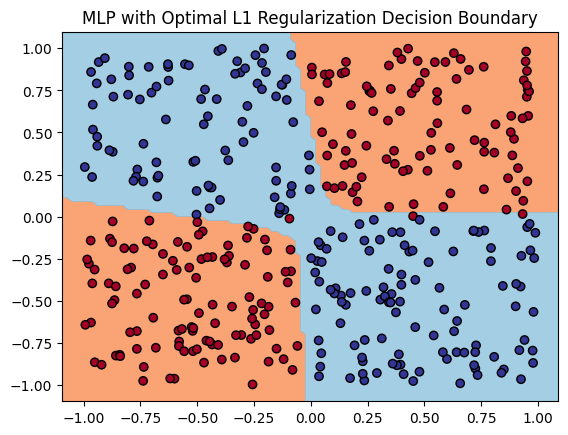

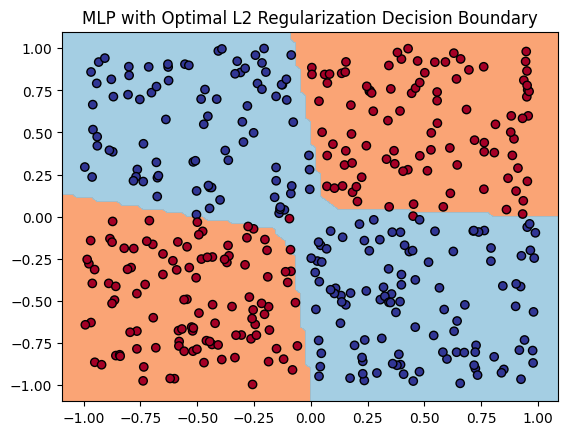

In [ ]:
lambdas = [0, 0.0001,0.005,0.001, 0.01, 0.1, 0.5, 1.0]

best_lambda_l1, best_accuracy_l1 = cross_validate_l1_l2(lambdas, 'L1', train_loader)
print(f"Best Lambda for L1: {best_lambda_l1}, Accuracy: {best_accuracy_l1 * 100:.2f}%")

best_lambda_l2, best_accuracy_l2 = cross_validate_l1_l2(lambdas, 'L2', train_loader)
print(f"Best Lambda for L2: {best_lambda_l2}, Accuracy: {best_accuracy_l2 * 100:.2f}%")

criterion = nn.BCELoss()

model_mlp_l1 = MLP()
optimizer_l1 = optim.Adam(model_mlp_l1.parameters(), lr=0.01)
def l1_penalty(model, lmbda):
    return sum(p.abs().sum() for p in model.parameters()) * lmbda
train_model_l1_l2(model_mlp_l1, optimizer_l1, criterion, train_loader, l1_penalty, best_lambda_l1)
accuracy_mlp_l1 = evaluate_model(model_mlp_l1, test_loader)
print(f"MLP with L1 Regularization (Optimal Lambda) Accuracy: {accuracy_mlp_l1 * 100:.2f}%")

model_mlp_l2 = MLP()
optimizer_l2 = optim.Adam(model_mlp_l2.parameters(), lr=0.01, weight_decay=best_lambda_l2)
train_model(model_mlp_l2, optimizer_l2, criterion, train_loader)
accuracy_mlp_l2 = evaluate_model(model_mlp_l2, test_loader)
print(f"MLP with L2 Regularization (Optimal Lambda) Accuracy: {accuracy_mlp_l2 * 100:.2f}%")


def plot_decision_boundary(model, title):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).detach().numpy().reshape(-1) > 0.5
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.RdYlBu)
    plt.title(title)
    plt.show()

plot_decision_boundary(model_mlp_l1, "MLP with Optimal L1 Regularization Decision Boundary")
plot_decision_boundary(model_mlp_l2, "MLP with Optimal L2 Regularization Decision Boundary")

As we know that XOR dataset cannot be lineraly separated we expect a non linear boundary surface, and L1 regularisation increases sparsity that is makes few parameters to be zero and it separated them reasonably good some of the misclassifications may be due to noisy data or over sparsity.
We know L2 will not make the weights of parameters zero but small, however it is similar to L1 but a bit smoother and more flexible.

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_poly)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_poly)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

Logistic Regression with Polynomial Features Accuracy: 95.00%


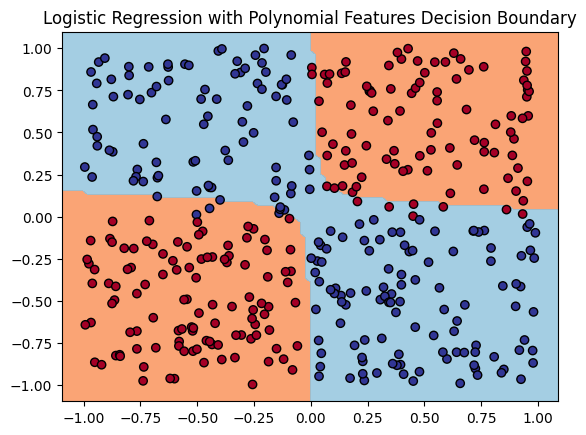

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = torch.sigmoid(self.linear(x))
        return x

def train_model(model, optimizer, criterion, train_loader, epochs=100):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            predicted = (output > 0.5).float()
            correct += (predicted == target).sum().item()
    return correct / len(test_loader.dataset)

input_dim = X_train_poly.shape[1]
model = LogisticRegressionModel(input_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = nn.BCELoss()

train_model(model, optimizer, criterion, train_loader, epochs=100)
accuracy = evaluate_model(model, test_loader)
print(f"Logistic Regression with Polynomial Features Accuracy: {accuracy * 100:.2f}%")

def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    poly_grid = poly.transform(np.c_[xx.ravel(), yy.ravel()])
    poly_grid_tensor = torch.FloatTensor(poly_grid)

    with torch.no_grad():
        Z = model(poly_grid_tensor).detach().numpy().reshape(-1) > 0.5
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.RdYlBu)
    plt.title(title)
    plt.show()

plot_decision_boundary(model, X, y, "Logistic Regression with Polynomial Features Decision Boundary")

This is the decision boundary when used with polynomial features, it tranforms into a higher dimenstional space where the boundary is linear but not in original space by using polynomials we get a clean and decision boundary likely more a bit curved.The accuracy is lower than other two with MLP due to non capturing of complex strucutre of data.